In [7]:
import numpy as np
import cv2 as cv
import pywt
import heapq
import os
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(699.5), np.float64(699.5), np.float64(-0.5))

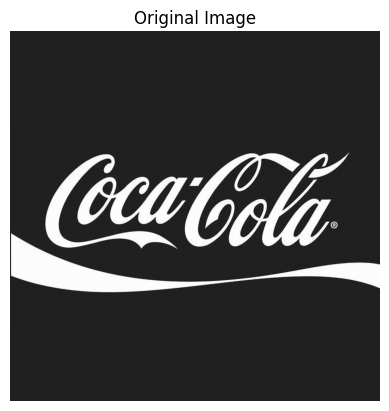

In [8]:
list_path = os.getcwd().split(os.sep)
list_path.pop()
list_path.pop()
list_path.append('images')
image_path = os.sep.join(list_path) + os.sep + 'coca-cola-logo.bmp'


img = cv.imread(image_path,0)
if img is None:
    print("Error: Image not found.")
    exit(1)


plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')


In [21]:
from collections import Counter

class HuffmanNode:
    def __init__(self, value, freq):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None
        
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = Counter(data.flatten())
    heap = [HuffmanNode(k, v) for k, v in freq.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
        
    return heap[0]

def build_codes(node, prefix="", codebook={}):
    if node is None:
        return
    if node.value is not None:
        codebook[node.value] = prefix
    build_codes(node.left, prefix + "0", codebook)
    build_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_compress(image):
    tree = build_huffman_tree(image)
    codebook = build_codes(tree)
    
    encoded = "".join(codebook[pixel] for pixel in image.flatten())
    compressed_size = len(encoded)  # bits
    
    return compressed_size


def dct_compress(image, keep_ratio=0.1):
    image = image.astype(np.float32)
    dct = cv.dct(image)
    
    M, N = dct.shape
    mask = np.zeros_like(dct)
    
    keep_M = int(M * keep_ratio)
    keep_N = int(N * keep_ratio)
    
    mask[:keep_M, :keep_N] = 1
    compressed = dct * mask
    
    non_zero = np.count_nonzero(compressed)
    compressed_size = non_zero * 32  # float32 = 32 bits
    
    return compressed_size


def dwt_compress_fixed(image, threshold=40.0, levels=4, wavelet='bior4.4'):
    img = image.astype(np.float32)
    coeffs = pywt.wavedec2(img, wavelet, level=levels)
    
    total_nonzero = 0
    
    # LL - gentle threshold
    LL = coeffs[0]
    LL[np.abs(LL) < threshold / 4] = 0
    total_nonzero += np.count_nonzero(LL)
    
    # Details - stronger threshold, increases per level
    for i, (LH, HL, HH) in enumerate(coeffs[1:], 1):
        thr = threshold * (1.5 ** i)
        LH[np.abs(LH) < thr] = 0
        HL[np.abs(HL) < thr] = 0
        HH[np.abs(HH) < thr] = 0
        total_nonzero += np.count_nonzero(LH) + np.count_nonzero(HL) + np.count_nonzero(HH)
    
    # More realistic bit estimate: ~6 bits per non-zero after entropy coding
    estimated_bits = int(total_nonzero * 6.0)
    
    return estimated_bits

huffman_size = huffman_compress(img)
original_size = img.size * 8  # bits  
print("Original Size (bits):", original_size)  
print("Huffman Size (bits):", huffman_size)
print("Huffman Compression Ratio:", original_size / huffman_size)

dct_size = dct_compress(img, keep_ratio=0.1)
print("DCT Size (bits):", dct_size)
print("DCT Compression Ratio:", original_size / dct_size)


dwt_size = dwt_compress_fixed(img, threshold=10)
print("DWT Size (bits):", dwt_size)
print("DWT Compression Ratio:", original_size / dwt_size)


Original Size (bits): 3920000
Huffman Size (bits): 949768
Huffman Compression Ratio: 4.127323725372933
DCT Size (bits): 156800
DCT Compression Ratio: 25.0
DWT Size (bits): 84156
DWT Compression Ratio: 46.58016065402348
